In [ ]:
%env "WANDB_NOTEBOOK_NAME" "14_hetero_poly_loss_strat.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: "WANDB_NOTEBOOK_NAME"="14_hetero_poly_loss_strat.ipynb"
env: WANDB_SILENT=True
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.3


In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

import os
import sys
import logging
from tqdm.notebook import trange
import wandb

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
input_size = 1
hidden_sizes = [10, 10] 
output_size = 1
initial_activation_list = [jax.nn.relu, jax.nn.tanh, sin]
activation_list = [jax.nn.relu, jax.nn.tanh, sin]
bias = False
num_epochs = 3000
add_node_every = 50
seed = 0
key = jax.random.PRNGKey(seed)
threshold = 1e-4
n_samples = 2000
learning_rate = 0.01

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                seed=seed)

2024-06-04 13:07:32.382968: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'add_node_every': add_node_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [ ]:
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
Description = f"Hetero_poly_loss_strat__no_bias_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{add_node_every}_{threshold}_{seed}"
fig_folder = f"../../figures/{Description}"
out_folder = f"../../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

In [ ]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 4
Description: Hetero_poly_loss_strat__no_bias_10_10_3000_50_0.0001_0
jax backend: cpu
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]


In [ ]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
mlp = CustomMLP(config)

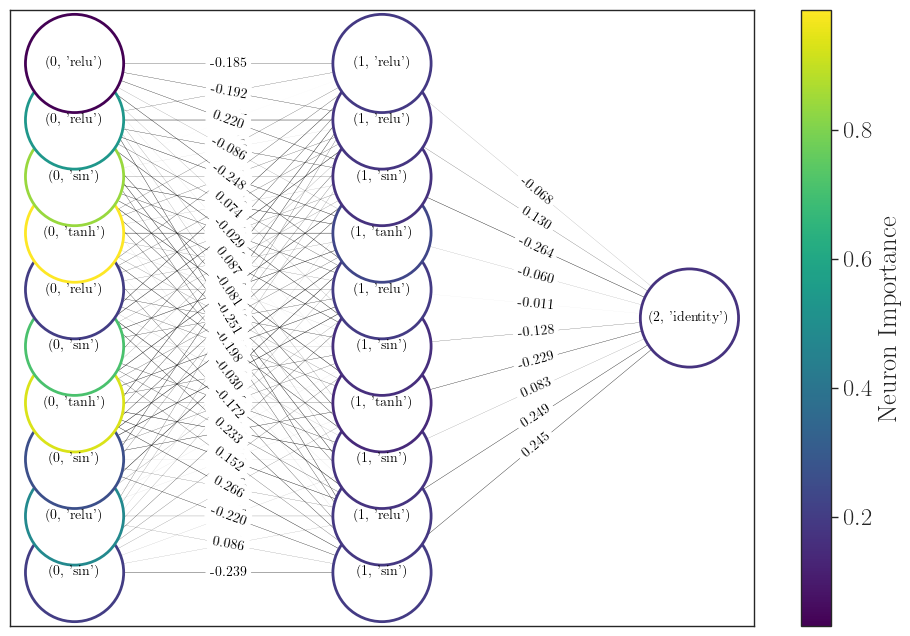

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/initial_graph.png")
wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
def poly(x):
    return (x - 3)*(x - 2)*(x - 1)*x*(x + 1)*(x + 2)*(x + 3)

In [ ]:
x = jnp.linspace(-3, 3, n_samples).reshape(-1, 1)
y = poly(x)

[<matplotlib.lines.Line2D>]

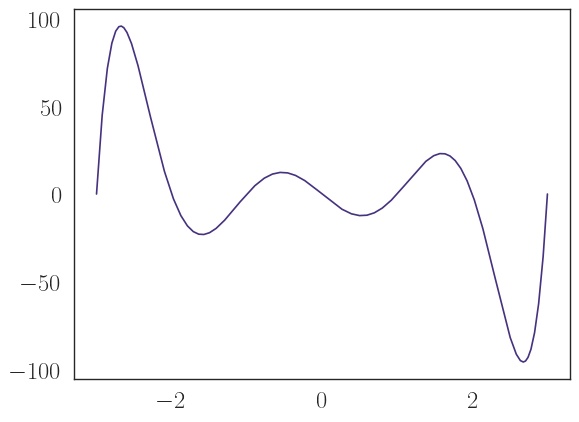

In [ ]:
plt.plot(x,y)

In [ ]:
opt = optax.adabelief(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

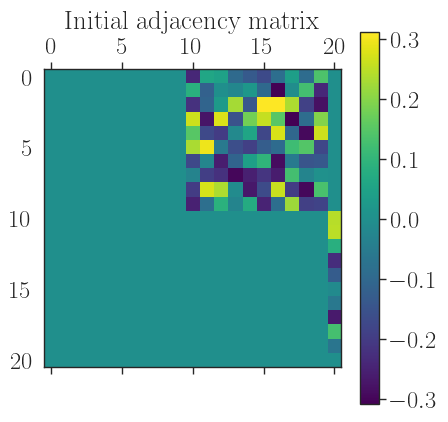

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

In [ ]:
Loss_history = []
Node_history = []
graph_history = []
Update_history = []

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    logging.info(f"Epoch {epoch :03d}, Loss: {loss.item()}, Neurons: {n_neurons}")
    wandb.log({"loss": loss.item(), "neurons": n_neurons})
    Loss_history.append(loss)
    Node_history.append(n_neurons)


    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:

        #add criterion
        if len(Update_history) == 0 or Update_history[-1][2] > loss or (Update_history[-1][3] == "removed" and Update_history[-2][3] == "removed" ):
            # if no previous addition or last addition was rejected, add a neuron
            # if last addition was accepted, add a neuron
            # if two removals in a row, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layers = len(mlp.get_shape()) - 1
            layer = jax.random.randint(act_key, (1,), 0, layers)[0]
            mlp.add_neuron(layer_index=layer, activation=activation, bias = bias, key=add_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer))
            logging.info(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
            wandb.log({"added neuron": activation.__name__})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        
        # remove criteria
        elif (Update_history[-1][3] == "removed" and Update_history[-2][2] < loss) or \
            (Update_history[-1][3] != "removed" and Update_history[-1][2] < loss):
            # if last addition was removed check loss against value before that
            # if last addition was accepted, check loss against it
            # if loss doesn't improve, reject it
            layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
            layer = Update_history[-1][4]
            neuron_idx = len(mlp.layers[layer]) -1

            if len(mlp.layers[layer]) <= 1:
                logging.info(f"Cannot remove neuron from layer {layer+1}, only one neuron left")
                Update_history.append((epoch, n_neurons, loss, "single_node_layer", layer))
                continue

            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer))

            logging.info(f"Removed neuron to hidden layer {layer+1} at index {neuron_idx}")
            wandb.log({"removed neuron": neuron_idx})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        
        
    if loss < threshold:
        # if loss is below threshold, stop training
        logging.info(f"Threshold reached, stopping training at epoch {epoch}")
        wandb.log({"threshold reached": epoch})
        break



Epoch 000, Loss: 1518.5508831856666, Neurons: 21
Epoch 001, Loss: 1514.773185194275, Neurons: 21
Epoch 002, Loss: 1510.7757837521845, Neurons: 21
Epoch 003, Loss: 1506.5824261829907, Neurons: 21
Epoch 004, Loss: 1502.2306058179622, Neurons: 21
Epoch 005, Loss: 1497.669916385417, Neurons: 21
Epoch 006, Loss: 1492.8752765428615, Neurons: 21
Epoch 007, Loss: 1487.8254110633984, Neurons: 21
Epoch 008, Loss: 1482.4949306010608, Neurons: 21
Epoch 009, Loss: 1476.8509463057285, Neurons: 21
Epoch 010, Loss: 1470.8598004634734, Neurons: 21
Epoch 011, Loss: 1464.4936578222032, Neurons: 21
Epoch 012, Loss: 1457.7290875408264, Neurons: 21
Epoch 013, Loss: 1450.5409456453044, Neurons: 21
Epoch 014, Loss: 1442.8964676816092, Neurons: 21
Epoch 015, Loss: 1434.752437391871, Neurons: 21
Epoch 016, Loss: 1426.0562889885655, Neurons: 21
Epoch 017, Loss: 1416.749748989965, Neurons: 21
Epoch 018, Loss: 1406.7728851147206, Neurons: 21
Epoch 019, Loss: 1396.0679904549486, Neurons: 21
Epoch 020, Loss: 1384.58

In [ ]:
np.savetxt(f"{out_folder}/neurons.txt", Node_history)
np.savetxt(f"{out_folder}/loss.txt", Loss_history)

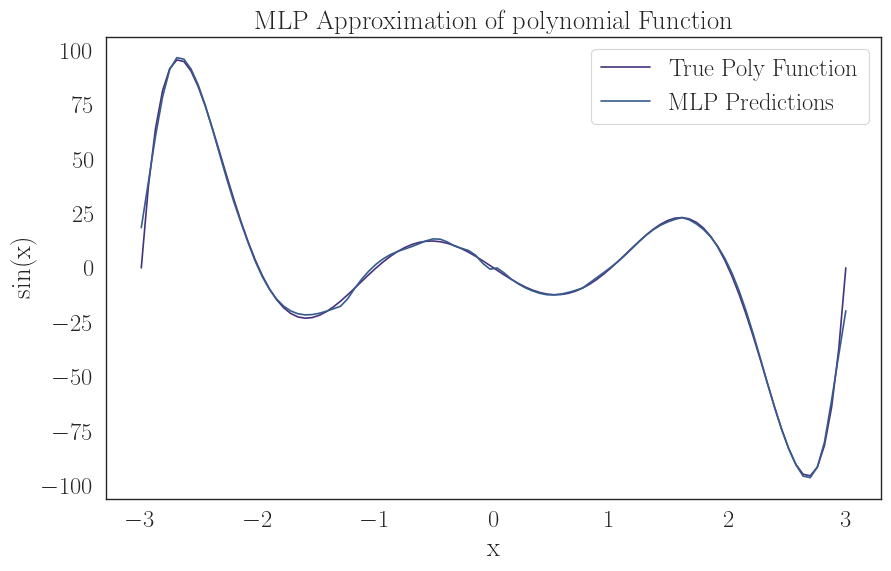

In [ ]:
x_test = jnp.linspace(-3, 3, 100).reshape(-1, 1)
y_test = poly(x_test)
y_pred = jax.vmap(mlp)(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, label="True Poly Function")
plt.plot(x_test, y_pred, label="MLP Predictions")
plt.legend()
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("MLP Approximation of polynomial Function")
plt.savefig(f"{fig_folder}/polynomial_approximation.png")
wandb.log({"polynomial approximation": wandb.Image(plt, caption="polynomial approximation")})


In [ ]:
Update_history

[(49, 21, Array(988.4984068, dtype=float64), 'relu', Array(1, dtype=int64)),
 (99, 22, Array(810.29502358, dtype=float64), 'relu', Array(1, dtype=int64)),
 (149, 23, Array(710.24681661, dtype=float64), 'sin', Array(0, dtype=int64)),
 (199, 24, Array(601.88846797, dtype=float64), 'sin', Array(1, dtype=int64)),
 (249, 25, Array(477.20751166, dtype=float64), 'sin', Array(0, dtype=int64)),
 (299, 26, Array(376.63564616, dtype=float64), 'relu', Array(1, dtype=int64)),
 (349, 27, Array(146.70784613, dtype=float64), 'tanh', Array(0, dtype=int64)),
 (399, 28, Array(91.96971658, dtype=float64), 'relu', Array(0, dtype=int64)),
 (449, 29, Array(67.62599674, dtype=float64), 'relu', Array(1, dtype=int64)),
 (499, 30, Array(57.27586704, dtype=float64), 'tanh', Array(0, dtype=int64)),
 (549, 31, Array(53.69957849, dtype=float64), 'tanh', Array(0, dtype=int64)),
 (599, 32, Array(42.62942292, dtype=float64), 'tanh', Array(1, dtype=int64)),
 (649, 33, Array(35.34608492, dtype=float64), 'relu', Array(0, 

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

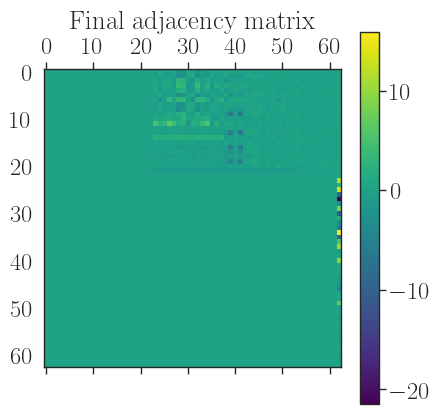

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

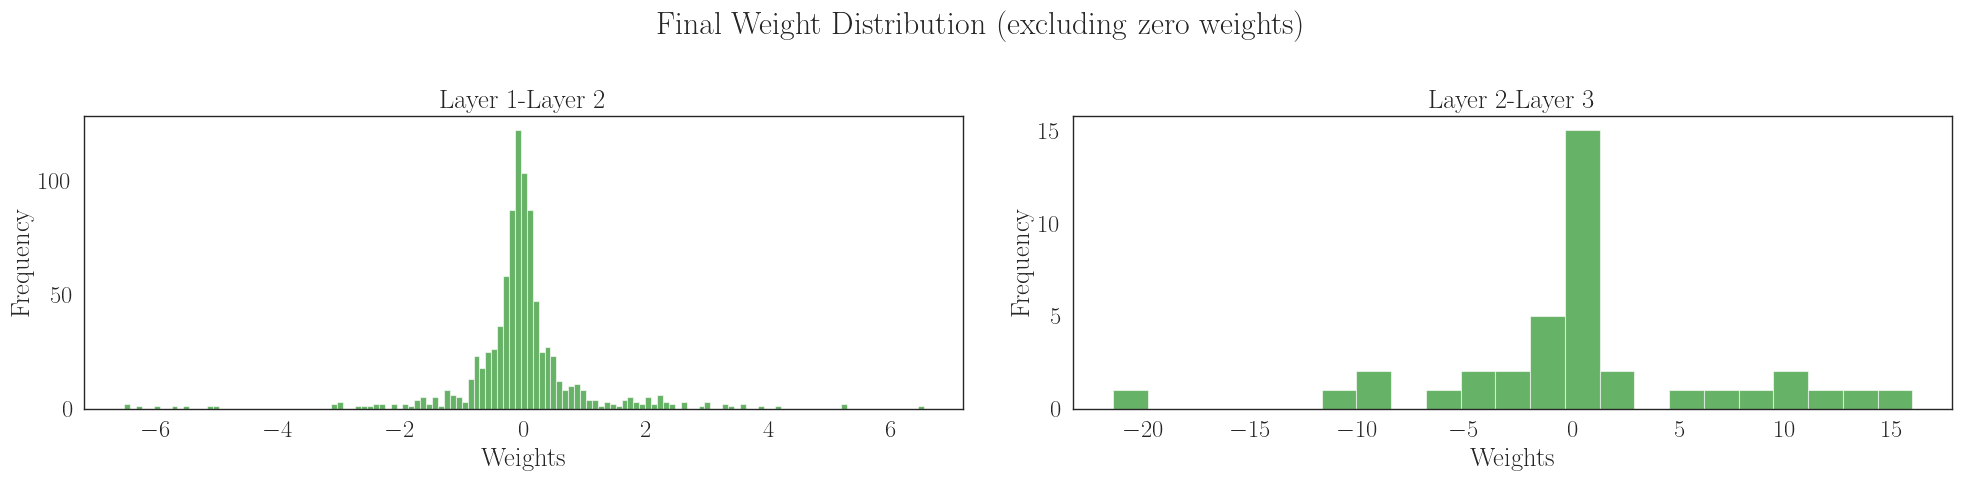

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum(mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

# Display the figure with its subplots
plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.show()

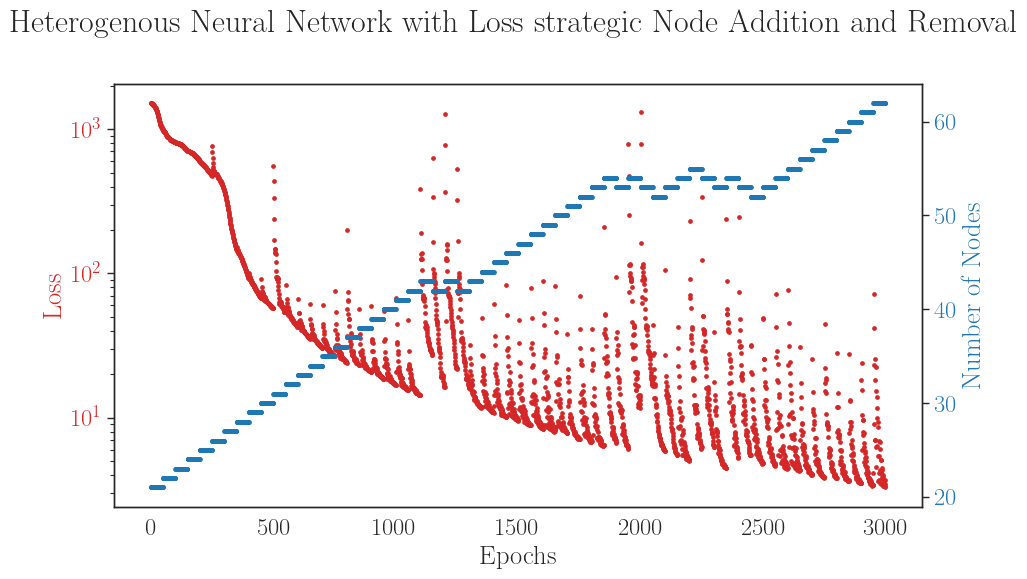

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Heterogenous Neural Network with Loss strategic Node Addition and Removal")
fig.tight_layout()

plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

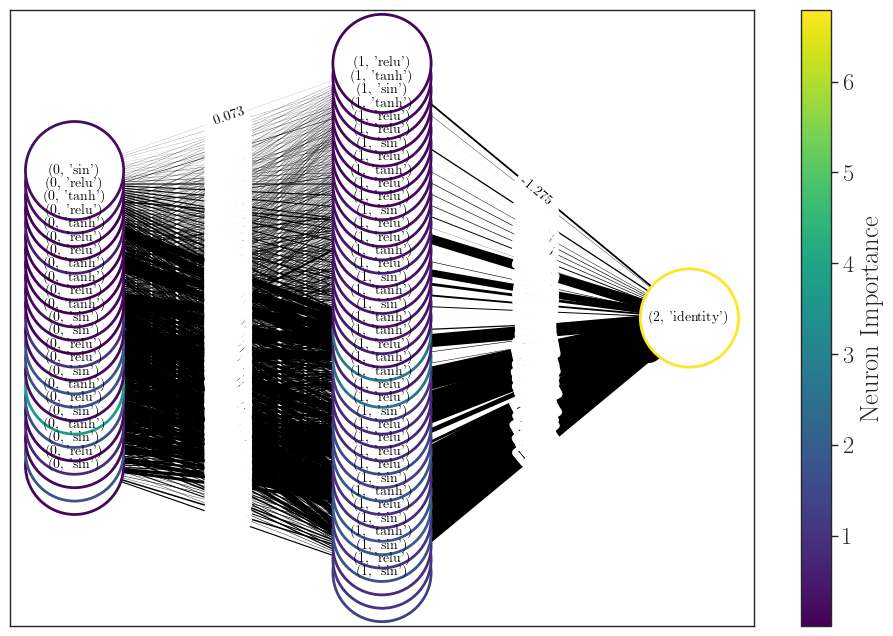

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [ ]:
wandb.finish()